# NBA Player Stats - Modeling

## Capstone Project Two

Build different models to cluster NBA players into different groups that go beyond the traditional positional groupings of (PG, SG, SF, PF, C). 

## Imports

In [1]:
# Import relevant libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, v_measure_score, silhouette_samples

# Suppress future warning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Prepare the notebook for matplotlib and other libraries- show plots inline
%matplotlib inline

sns.set_style("whitegrid")

## Loading Data

In [2]:
# Load data
nba_df = pd.read_csv('NBA-Clustering/data/interim/nba_stats_cleaned.csv',  index_col=0)

## Explore Data

In [3]:
# View df appearance
nba_df.head(10)

Player Pos   G    MP   FG   FGA    FG%   3P  3PA    3P%  \
0           Precious Achiuwa   C  73  23.6  3.6   8.3  0.439  0.8  2.1  0.359   
1               Steven Adams   C  76  26.3  2.8   5.1  0.547  0.0  0.0  0.000   
2                Bam Adebayo   C  56  32.6  7.3  13.0  0.557  0.0  0.1  0.000   
3               Santi Aldama  PF  32  11.3  1.7   4.1  0.402  0.2  1.5  0.125   
4          LaMarcus Aldridge   C  47  22.3  5.4   9.7  0.550  0.3  1.0  0.304   
5   Nickeil Alexander-Walker  SG  65  22.6  3.9  10.5  0.372  1.6  5.2  0.311   
8              Grayson Allen  SG  66  27.3  3.9   8.6  0.448  2.4  5.9  0.409   
9              Jarrett Allen   C  56  32.3  6.6   9.7  0.677  0.0  0.2  0.100   
10             Jose Alvarado  PG  54  15.4  2.4   5.4  0.446  0.6  2.0  0.291   
11           Justin Anderson  SF  16  19.8  2.3   5.9  0.379  0.9  3.7  0.254   

    ...    FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
0   ...  0.595  2.0  4.5   6.5  1.1  0.5  0.6  1.2  2.1   9.1  
1   ...  0.543  4.6  5.4  10.0  3.4  0.9  0.8  1.5  2.0   6.9  
2   ...  0.753  2.4  7.6  10.1  3.4  1.4  0.8  2.6  3.1  19.1  
3   ...  0.625  1.0  1.7   2.7  0.7  0.2  0.3  0.5  1.1   4.1  
4   ...  0.873  1.6  3.9   5.5  0.9  0.3  1.0  0.9  1.7  12.9  
5   ...  0.743  0.6  2.3   2.9  2.4  0.7  0.4  1.4  1.6  10.6  
8   ...  0.865  0.5  2.9   3.4  1.5  0.7  0.3  0.7  1.5  11.1  
9   ...  0.708  3.4  7.3  10.8  1.6  0.8  1.3  1.7  1.7  16.1  
10  ...  0.679  0.5  1.4   1.9  2.8  1.3  0.1  0.7  1.4   6.1  
11  ...  0.789  0.3  2.6   2.9  2.1  0.5  0.4  0.5  1.4   6.4  

[10 rows x 26 columns]

In [4]:
# Set indexes to "Player"
nba_df = nba_df.set_index('Player')

# Save "Player" column names
nba_player = nba_df.index

# View new df
nba_df.head()

Pos   G    MP   FG   FGA    FG%   3P  3PA    3P%   2P  ...  \
Player                                                                   ...   
Precious Achiuwa    C  73  23.6  3.6   8.3  0.439  0.8  2.1  0.359  2.9  ...   
Steven Adams        C  76  26.3  2.8   5.1  0.547  0.0  0.0  0.000  2.8  ...   
Bam Adebayo         C  56  32.6  7.3  13.0  0.557  0.0  0.1  0.000  7.3  ...   
Santi Aldama       PF  32  11.3  1.7   4.1  0.402  0.2  1.5  0.125  1.5  ...   
LaMarcus Aldridge   C  47  22.3  5.4   9.7  0.550  0.3  1.0  0.304  5.1  ...   

                     FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
Player                                                                   
Precious Achiuwa   0.595  2.0  4.5   6.5  1.1  0.5  0.6  1.2  2.1   9.1  
Steven Adams       0.543  4.6  5.4  10.0  3.4  0.9  0.8  1.5  2.0   6.9  
Bam Adebayo        0.753  2.4  7.6  10.1  3.4  1.4  0.8  2.6  3.1  19.1  
Santi Aldama       0.625  1.0  1.7   2.7  0.7  0.2  0.3  0.5  1.1   4.1  
LaMarcus Aldridge  0.873  1.6  3.9   5.5  0.9  0.3  1.0  0.9  1.7  12.9  

[5 rows x 25 columns]

In [5]:
# Check column names
nba_df.columns

Index(['Pos', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [6]:
# Feature Selection
features = ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS']

In [7]:
# Set feature and label variables
X = nba_df[features]
labels = nba_df.Pos

## Scaling Data

In [8]:
# Make Scaler object
scaler = StandardScaler()

# Fit scaler and apply to data
X = scaler.fit_transform(X)

In [9]:
#Re-introduce column names back into new scaled df
X = pd.DataFrame(X, columns=features)

In [10]:
# View new scaled df
X.head()

G        MP        FG       FGA       FG%        3P       3PA  \
0  1.068329  0.313608  0.068946  0.165488 -0.203596 -0.277375 -0.382884   
1  1.215793  0.619889 -0.286904 -0.506714  1.059811 -1.196596 -1.299084   
2  0.232698  1.334543  1.714754  1.152783  1.176793 -1.196596 -1.255455   
3 -0.947015 -1.081669 -0.776199 -0.716777 -0.636429 -0.966791 -0.644655   
4 -0.209694  0.166140  0.869609  0.459576  1.094906 -0.851888 -0.862798   

        3P%        2P       2PA  ...       FT%       ORB       DRB       TRB  \
0  0.427411  0.271534  0.467934  ... -0.933386  1.471679  0.880299  1.137839   
1 -2.745210  0.216701  0.138993  ... -1.270339  4.989206  1.382880  2.632635   
2 -2.745210  2.684191  2.501388  ...  0.090433  2.012837  2.611413  2.675343   
3 -1.640537 -0.496130 -0.578697  ... -0.738990  0.118784 -0.683287 -0.485083   
4 -0.058645  1.477862  1.275335  ...  0.868017  0.930521  0.545245  0.710754   

        AST       STL       BLK       TOV        PF       PTS  
0 -0.535171 -0.410317  0.489769  0.083711  0.498505 -0.040755  
1  0.701410  0.623228  1.020397  0.449795  0.358002 -0.392646  
2  0.701410  1.915159  1.020397  1.792103  1.903536  1.558747  
3 -0.750228 -1.185476 -0.306172 -0.770485 -0.906526 -0.840506  
4 -0.642699 -0.927090  1.551024 -0.282373 -0.063507  0.567055  

[5 rows x 24 columns]

## Modeling

### Principal Component Analysis (PCA)

In [11]:
# Dimension Reduction for more efficient analysis
variance_list = []

for n_components in range(2, 25):
    pca = PCA(n_components = n_components)
    components = pca.fit_transform(X)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print("For n_components = {}, explained variance ratio is {}".format(n_components, variance))

For n_components = 2, explained variance ratio is 0.6858466171911651
For n_components = 3, explained variance ratio is 0.7614908259239215
For n_components = 4, explained variance ratio is 0.8072957711614266
For n_components = 5, explained variance ratio is 0.8400683661203946
For n_components = 6, explained variance ratio is 0.8718288258410456
For n_components = 7, explained variance ratio is 0.8969794379515902
For n_components = 8, explained variance ratio is 0.9198429020677616
For n_components = 9, explained variance ratio is 0.9359345432506359
For n_components = 10, explained variance ratio is 0.9501945647932677
For n_components = 11, explained variance ratio is 0.9636757868643541
For n_components = 12, explained variance ratio is 0.9743909285555331
For n_components = 13, explained variance ratio is 0.9846749657139924
For n_components = 14, explained variance ratio is 0.9913002758251953
For n_components = 15, explained variance ratio is 0.9954123182292081
For n_components = 16, expla

Text(0.5, 0.98, 'Explained Variance Per Component #')

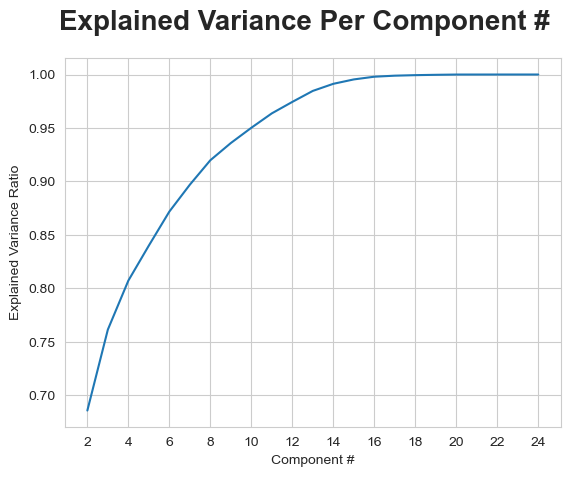

In [12]:
# plot the components
pca_fig, ax = plt.subplots()

ax.plot(range(2, 25), variance_list)

ax.set_xlabel('Component #')
ax.set_ylabel('Explained Variance Ratio')

ax.set_xticks(np.arange(2, 25, 2.0))

pca_fig.suptitle("Explained Variance Per Component #", weight = 'bold', size = 20)

The first 10 components explain for about ~95% of the variance of the data. 

In [13]:
# Using 10 component, we will create new PCA object
pca = PCA(n_components = 10)

# Fit PCA and apply to data
nba_pca = pca.fit_transform(X)

In [14]:
components = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

# Create new df with components
pca_df = pd.DataFrame(data = nba_pca, columns = components)

In [15]:
# Add player names to visualize with components
pca_df['Player'] = nba_player
pca_df = pca_df.set_index('Player')
pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6  \
Player                                                                          
Precious Achiuwa   0.786201  1.103935  0.695150 -1.628810  1.310344  0.309444   
Steven Adams       1.746808  5.104019  2.106357 -2.386671 -0.709976 -0.859366   
Bam Adebayo        6.762261  3.771465  3.368587  0.188406 -1.494466  0.049672   
Santi Aldama      -3.292562  0.595180  1.628942  0.307131 -0.268122  0.166262   
LaMarcus Aldridge  1.546901  2.396895  0.281960  0.714185  0.226513  1.851230   

                        PC7       PC8       PC9      PC10  
Player                                                     
Precious Achiuwa   0.640343 -1.005798 -0.054870 -0.553709  
Steven Adams      -0.031805 -1.895424 -1.526435 -0.360329  
Bam Adebayo       -0.028240 -0.362089  0.027136 -0.404439  
Santi Aldama      -1.007701 -0.573947  0.055615 -0.065031  
LaMarcus Aldridge  0.204400  0.374865  0.154035  0.021698

### K-Means Clustering

#### Choosing Optimal K

Text(0, 0.5, 'Sum of Squares')

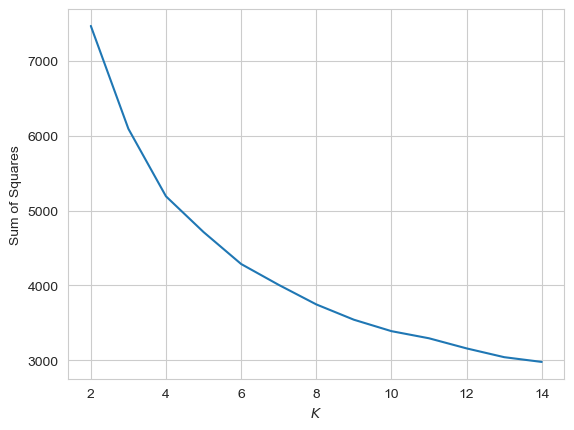

In [16]:
ss = []
assignments = {}

X = pca_df.to_numpy()

Krange = list(range(2, 15))

for K in Krange:
    model = KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster
    
plt.plot(Krange, ss)
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")

6


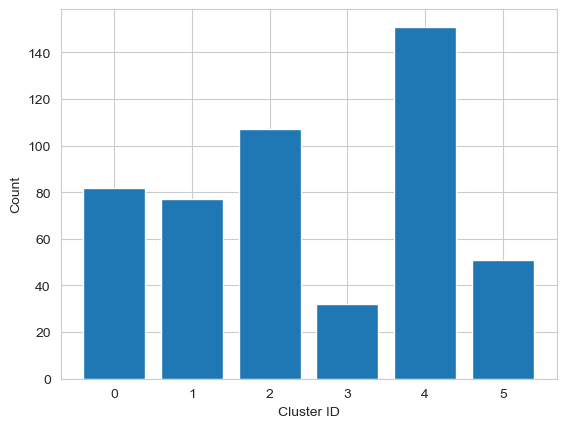

In [17]:
best_K = 6
assignments_best_K = assignments[str(best_K)]
counts = np.bincount(assignments_best_K)
print(len(counts))

# Plot distribution with best K
_ = plt.bar(range(best_K), counts, align='center')
_ = plt.xlabel("Cluster ID")
_ = plt.ylabel("Count")
_ = plt.xticks(range(best_K))

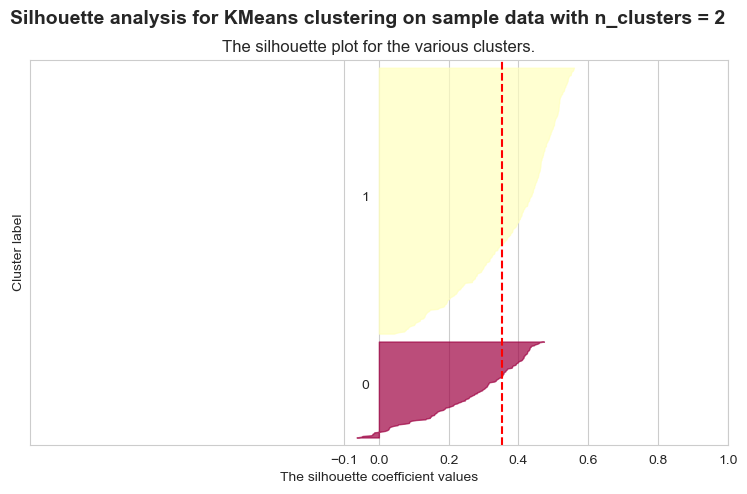

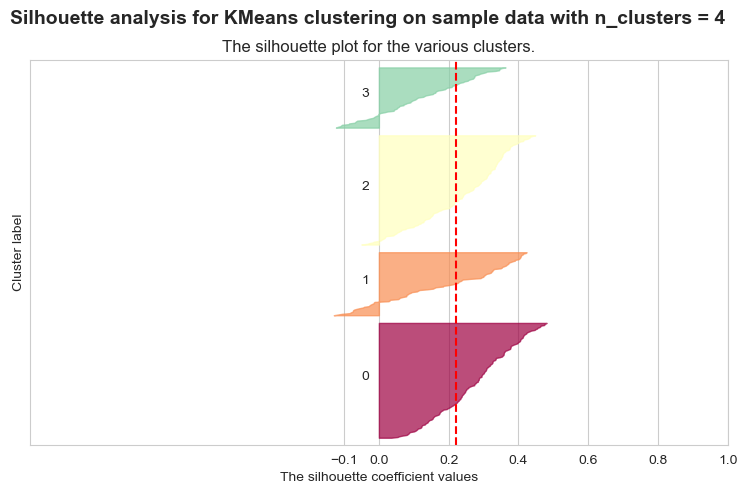

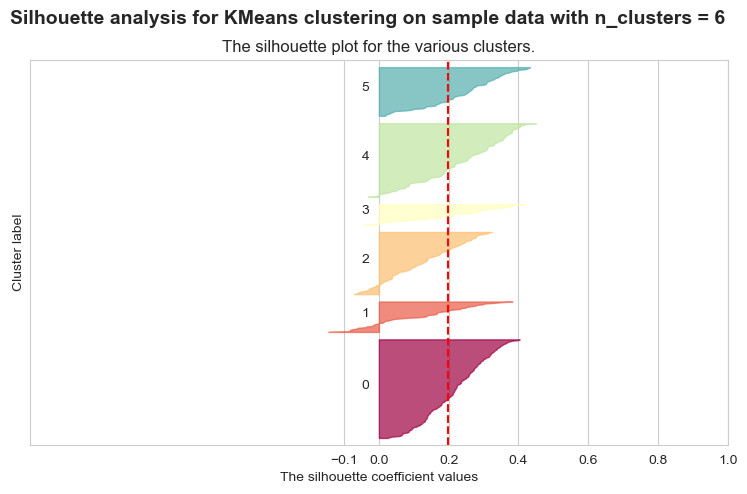

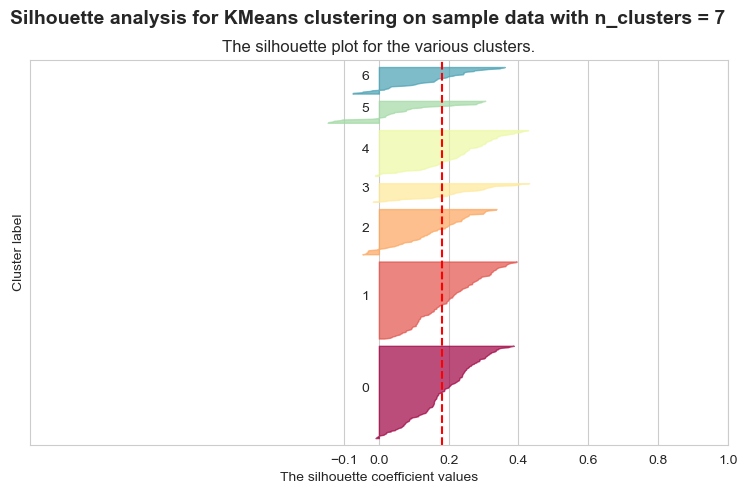

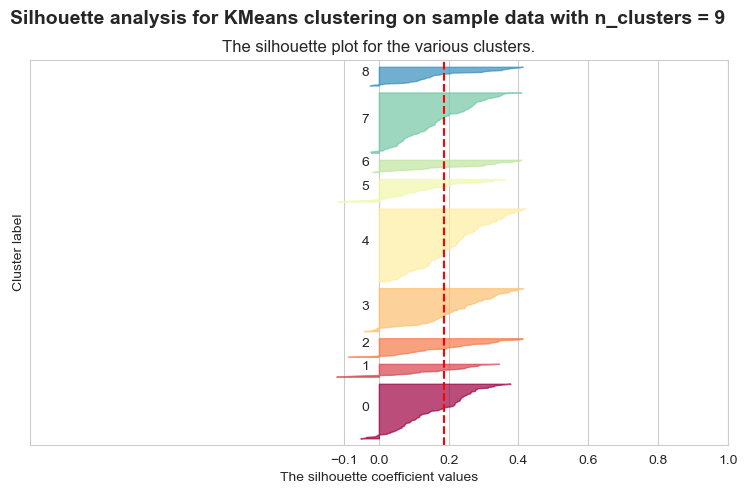

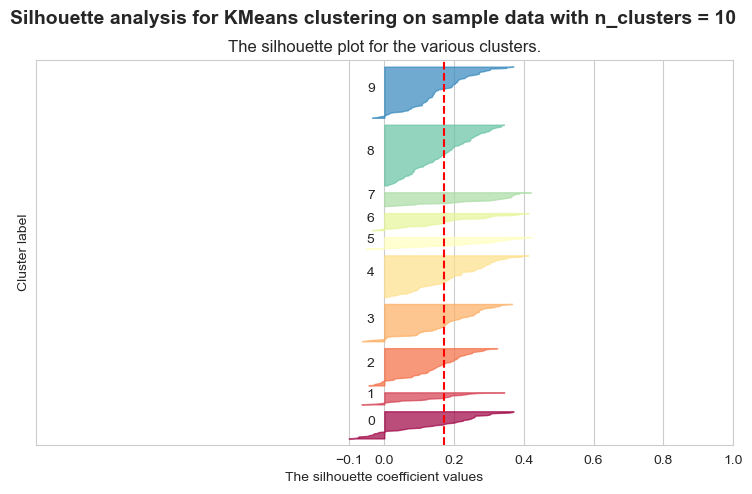

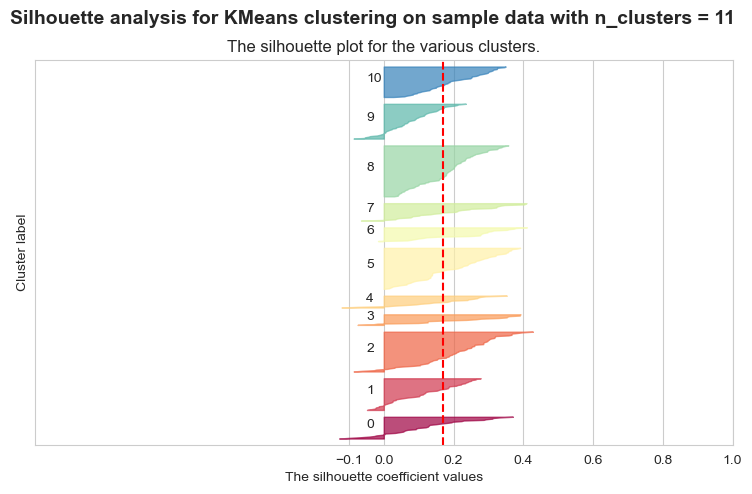

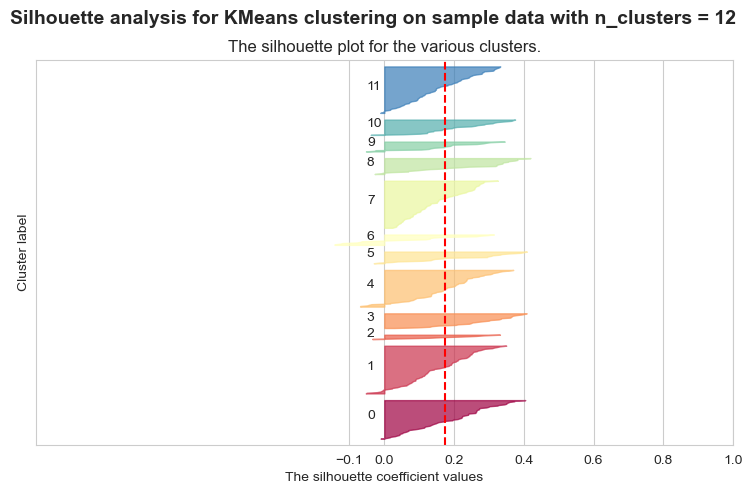

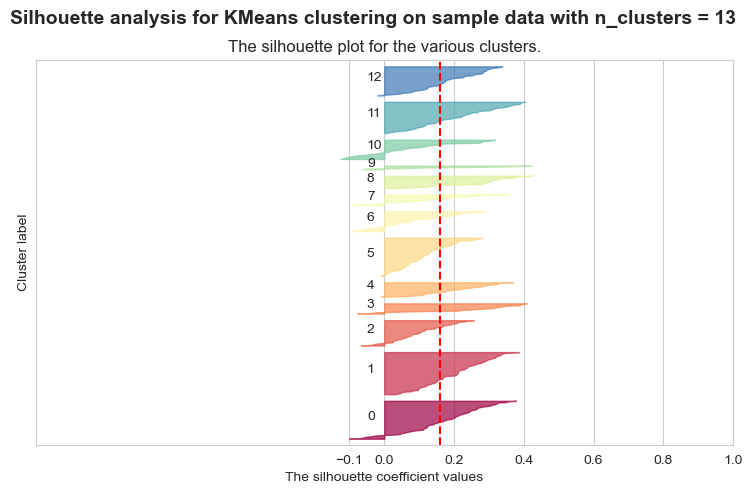

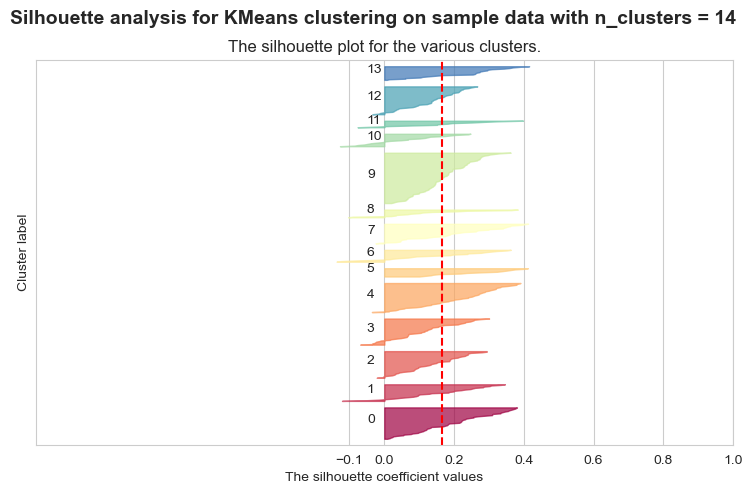

In [18]:
avg_silhouette_scores = []

for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 30 for reproducibility.
    clusterer = KMeans(n_clusters = K, random_state = 30)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg  = silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')

Text(0, 0.5, 'Average Silhouette Score')

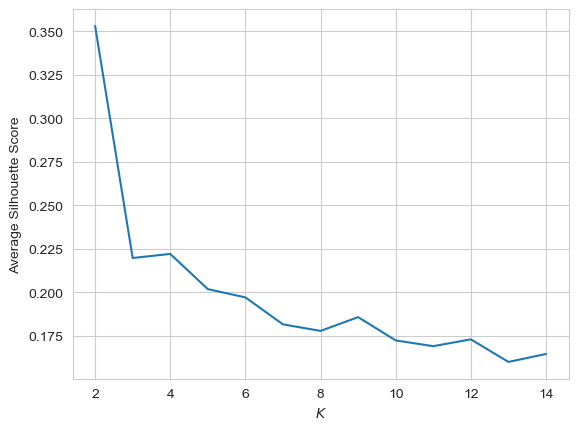

In [19]:
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")

Based on the Average Silhoueette Score plot of K, the K score seems to peak around K=4. 

In [20]:
# Kmeans Clustering
KC_labels = KMeans(n_clusters = 4, random_state = 30).fit_predict(X)

In [21]:
KC_labels

array([0, 3, 1, 2, 3, 0, 0, 3, 0, 2, 0, 1, 2, 0, 1, 1, 2, 2, 2, 0, 3, 3,
       3, 1, 0, 3, 1, 2, 1, 1, 1, 0, 3, 2, 0, 2, 0, 1, 0, 3, 2, 0, 1, 3,
       3, 3, 0, 0, 2, 0, 1, 2, 2, 2, 1, 2, 3, 2, 0, 3, 2, 0, 1, 0, 1, 2,
       1, 0, 2, 2, 1, 3, 2, 2, 1, 3, 0, 2, 0, 2, 1, 3, 0, 0, 2, 3, 2, 1,
       0, 2, 2, 2, 2, 0, 2, 3, 0, 3, 0, 1, 3, 0, 0, 2, 2, 2, 0, 0, 0, 0,
       2, 1, 0, 1, 1, 3, 0, 3, 1, 3, 3, 2, 0, 0, 1, 1, 0, 2, 2, 0, 3, 0,
       2, 0, 1, 1, 0, 0, 2, 1, 3, 2, 3, 2, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0,
       3, 3, 0, 1, 2, 2, 2, 0, 1, 3, 1, 1, 2, 3, 2, 1, 0, 0, 1, 0, 3, 1,
       3, 3, 0, 2, 0, 2, 2, 0, 1, 0, 0, 1, 2, 3, 0, 0, 1, 1, 3, 2, 2, 3,
       0, 1, 2, 3, 1, 0, 2, 0, 2, 2, 0, 1, 0, 3, 2, 0, 0, 2, 3, 2, 0, 2,
       0, 0, 3, 2, 0, 1, 1, 0, 3, 1, 2, 1, 1, 2, 2, 2, 0, 2, 3, 1, 0, 0,
       1, 3, 3, 0, 2, 2, 0, 3, 0, 2, 0, 3, 2, 0, 0, 2, 2, 3, 0, 2, 0, 0,
       1, 0, 2, 2, 1, 2, 0, 2, 3, 1, 2, 1, 0, 0, 3, 0, 3, 0, 1, 2, 0, 0,
       2, 0, 0, 2, 0, 2, 0, 0, 2, 3, 0, 2, 1, 2, 2,

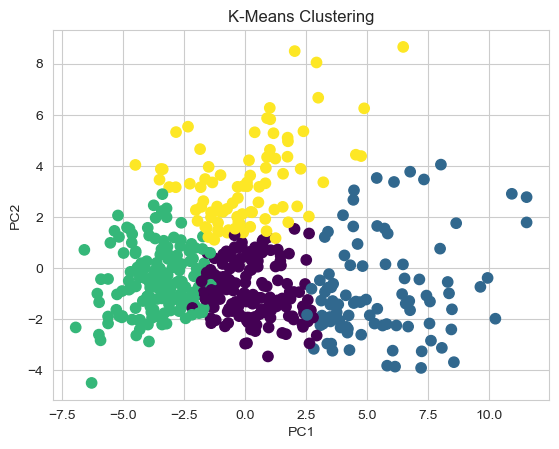

In [22]:
plt.scatter(X[:, 0], X[:, 1], c = KC_labels,
            s=55, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
_ = plt.title('K-Means Clustering')

In [23]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, KC_labels))

Silhouette Coefficient: 0.222


### Agglomerative Clustering

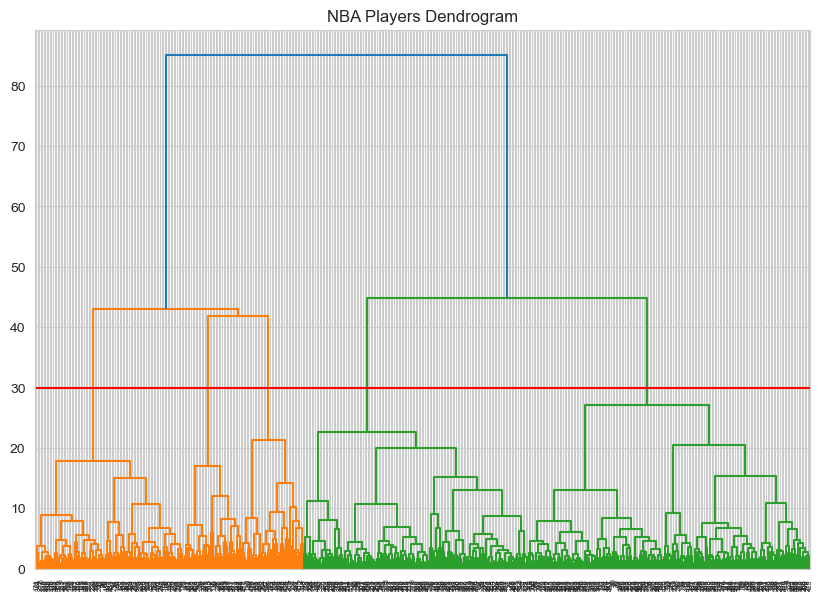

In [24]:
# Dendrogram
plt.figure(figsize=(10, 7))
plt.title("NBA Players Dendrogram")


cluster = linkage(X, method='ward', metric="euclidean")

dendrogram(cluster)

plt.axhline(y = 30, color = 'r', linestyle = '-')

To pick the optimal number of clusters, I identified the area in the chart with the highest vertical distance that does not interect with any clusters. The optimal number is 5. 

In [25]:
# Agglomerative Clustering with Ward Linkage
AC = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
AC.fit(X)
AC_labels = AC.labels_

In [26]:
AC_labels

array([0, 1, 1, 2, 0, 3, 3, 1, 2, 2, 0, 4, 0, 3, 3, 3, 2, 2, 2, 0, 1, 0,
       0, 4, 3, 1, 3, 2, 3, 1, 3, 3, 0, 0, 0, 2, 0, 4, 3, 0, 0, 3, 3, 0,
       0, 0, 0, 3, 2, 3, 3, 2, 2, 2, 4, 2, 0, 2, 0, 0, 2, 3, 1, 0, 3, 0,
       3, 0, 2, 0, 4, 0, 2, 2, 3, 0, 3, 2, 3, 2, 4, 0, 3, 2, 2, 1, 2, 1,
       3, 2, 2, 2, 0, 0, 2, 0, 3, 1, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 0, 0,
       2, 4, 3, 4, 1, 0, 0, 0, 4, 0, 0, 2, 3, 3, 4, 3, 0, 2, 2, 3, 1, 3,
       2, 3, 4, 4, 0, 0, 0, 4, 0, 2, 0, 2, 0, 2, 2, 0, 2, 3, 4, 2, 0, 3,
       0, 1, 0, 4, 2, 0, 0, 0, 4, 0, 1, 4, 2, 1, 2, 1, 3, 3, 3, 0, 1, 3,
       0, 0, 0, 0, 0, 0, 2, 0, 3, 2, 3, 4, 0, 0, 0, 3, 3, 1, 0, 2, 2, 0,
       3, 3, 2, 0, 3, 3, 2, 0, 2, 2, 0, 3, 3, 0, 2, 1, 3, 2, 0, 2, 3, 2,
       3, 0, 0, 2, 0, 4, 4, 0, 0, 1, 2, 3, 4, 2, 2, 2, 3, 2, 0, 3, 2, 0,
       4, 0, 0, 0, 2, 2, 0, 0, 0, 2, 3, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 2, 2, 2, 4, 2, 0, 2, 0, 3, 2, 4, 0, 0, 1, 0, 0, 3, 3, 2, 0, 2,
       2, 0, 3, 2, 3, 2, 0, 0, 2, 0, 0, 0, 3, 2, 2,

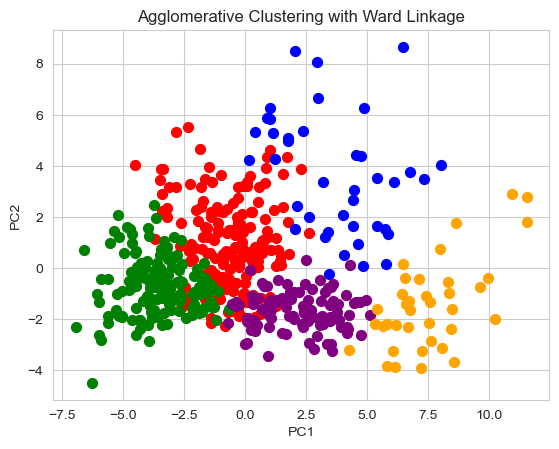

In [27]:
plt.scatter(X[AC_labels==0, 0], X[AC_labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[AC_labels==1, 0], X[AC_labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[AC_labels==2, 0], X[AC_labels==2, 1], s=50, marker='o', color='green')
plt.scatter(X[AC_labels==3, 0], X[AC_labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(X[AC_labels==4, 0], X[AC_labels==4, 1], s=50, marker='o', color='orange')

plt.xlabel('PC1')
plt.ylabel('PC2')
_ = plt.title('Agglomerative Clustering with Ward Linkage')
plt.show()

In [28]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, AC_labels))

Silhouette Coefficient: 0.184


### Analysis

In [29]:
# Add in cluster labels
nba_df['AC_Cluster'] = AC_labels
nba_df.head()

Pos   G    MP   FG   FGA    FG%   3P  3PA    3P%   2P  ...  \
Player                                                                   ...   
Precious Achiuwa    C  73  23.6  3.6   8.3  0.439  0.8  2.1  0.359  2.9  ...   
Steven Adams        C  76  26.3  2.8   5.1  0.547  0.0  0.0  0.000  2.8  ...   
Bam Adebayo         C  56  32.6  7.3  13.0  0.557  0.0  0.1  0.000  7.3  ...   
Santi Aldama       PF  32  11.3  1.7   4.1  0.402  0.2  1.5  0.125  1.5  ...   
LaMarcus Aldridge   C  47  22.3  5.4   9.7  0.550  0.3  1.0  0.304  5.1  ...   

                   ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  AC_Cluster  
Player                                                                        
Precious Achiuwa   2.0  4.5   6.5  1.1  0.5  0.6  1.2  2.1   9.1           0  
Steven Adams       4.6  5.4  10.0  3.4  0.9  0.8  1.5  2.0   6.9           1  
Bam Adebayo        2.4  7.6  10.1  3.4  1.4  0.8  2.6  3.1  19.1           1  
Santi Aldama       1.0  1.7   2.7  0.7  0.2  0.3  0.5  1.1   4.1           2  
LaMarcus Aldridge  1.6  3.9   5.5  0.9  0.3  1.0  0.9  1.7  12.9           0  

[5 rows x 26 columns]

In [30]:
nba_df['KC_Cluster'] = KC_labels
nba_df.head()

Pos   G    MP   FG   FGA    FG%   3P  3PA    3P%   2P  ...  \
Player                                                                   ...   
Precious Achiuwa    C  73  23.6  3.6   8.3  0.439  0.8  2.1  0.359  2.9  ...   
Steven Adams        C  76  26.3  2.8   5.1  0.547  0.0  0.0  0.000  2.8  ...   
Bam Adebayo         C  56  32.6  7.3  13.0  0.557  0.0  0.1  0.000  7.3  ...   
Santi Aldama       PF  32  11.3  1.7   4.1  0.402  0.2  1.5  0.125  1.5  ...   
LaMarcus Aldridge   C  47  22.3  5.4   9.7  0.550  0.3  1.0  0.304  5.1  ...   

                   DRB   TRB  AST  STL  BLK  TOV   PF   PTS  AC_Cluster  \
Player                                                                    
Precious Achiuwa   4.5   6.5  1.1  0.5  0.6  1.2  2.1   9.1           0   
Steven Adams       5.4  10.0  3.4  0.9  0.8  1.5  2.0   6.9           1   
Bam Adebayo        7.6  10.1  3.4  1.4  0.8  2.6  3.1  19.1           1   
Santi Aldama       1.7   2.7  0.7  0.2  0.3  0.5  1.1   4.1           2   
LaMarcus Aldridge  3.9   5.5  0.9  0.3  1.0  0.9  1.7  12.9           0   

                   KC_Cluster  
Player                         
Precious Achiuwa            0  
Steven Adams                3  
Bam Adebayo                 1  
Santi Aldama                2  
LaMarcus Aldridge           3  

[5 rows x 27 columns]

In [31]:
nba_df.head(10)

Pos   G    MP   FG   FGA    FG%   3P  3PA    3P%  \
Player                                                                      
Precious Achiuwa           C  73  23.6  3.6   8.3  0.439  0.8  2.1  0.359   
Steven Adams               C  76  26.3  2.8   5.1  0.547  0.0  0.0  0.000   
Bam Adebayo                C  56  32.6  7.3  13.0  0.557  0.0  0.1  0.000   
Santi Aldama              PF  32  11.3  1.7   4.1  0.402  0.2  1.5  0.125   
LaMarcus Aldridge          C  47  22.3  5.4   9.7  0.550  0.3  1.0  0.304   
Nickeil Alexander-Walker  SG  65  22.6  3.9  10.5  0.372  1.6  5.2  0.311   
Grayson Allen             SG  66  27.3  3.9   8.6  0.448  2.4  5.9  0.409   
Jarrett Allen              C  56  32.3  6.6   9.7  0.677  0.0  0.2  0.100   
Jose Alvarado             PG  54  15.4  2.4   5.4  0.446  0.6  2.0  0.291   
Justin Anderson           SF  16  19.8  2.3   5.9  0.379  0.9  3.7  0.254   

                           2P  ...  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  \
Player                         ...                                             
Precious Achiuwa          2.9  ...  4.5   6.5  1.1  0.5  0.6  1.2  2.1   9.1   
Steven Adams              2.8  ...  5.4  10.0  3.4  0.9  0.8  1.5  2.0   6.9   
Bam Adebayo               7.3  ...  7.6  10.1  3.4  1.4  0.8  2.6  3.1  19.1   
Santi Aldama              1.5  ...  1.7   2.7  0.7  0.2  0.3  0.5  1.1   4.1   
LaMarcus Aldridge         5.1  ...  3.9   5.5  0.9  0.3  1.0  0.9  1.7  12.9   
Nickeil Alexander-Walker  2.3  ...  2.3   2.9  2.4  0.7  0.4  1.4  1.6  10.6   
Grayson Allen             1.5  ...  2.9   3.4  1.5  0.7  0.3  0.7  1.5  11.1   
Jarrett Allen             6.6  ...  7.3  10.8  1.6  0.8  1.3  1.7  1.7  16.1   
Jose Alvarado             1.8  ...  1.4   1.9  2.8  1.3  0.1  0.7  1.4   6.1   
Justin Anderson           1.3  ...  2.6   2.9  2.1  0.5  0.4  0.5  1.4   6.4   

                          AC_Cluster  KC_Cluster  
Player                                            
Precious Achiuwa                   0           0  
Steven Adams                       1           3  
Bam Adebayo                        1           1  
Santi Aldama                       2           2  
LaMarcus Aldridge                  0           3  
Nickeil Alexander-Walker           3           0  
Grayson Allen                      3           0  
Jarrett Allen                      1           3  
Jose Alvarado                      2           0  
Justin Anderson                    2           2  

[10 rows x 27 columns]

In [32]:
# Check AC Cluster Size
nba_df['AC_Cluster'].value_counts().sort_index()

0    182
1     40
2    145
3     96
4     37
Name: AC_Cluster, dtype: int64

Text(0, 0.5, 'Count')

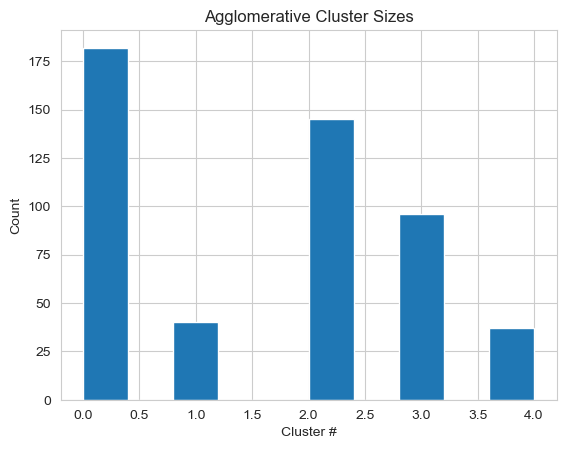

In [33]:
# Plot AC Cluster Distribution
plt.hist(nba_df['AC_Cluster'])
plt.title('Agglomerative Cluster Sizes')
plt.xlabel('Cluster #')
plt.ylabel('Count')

In [34]:
# Check KC Cluster Size
nba_df['KC_Cluster'].value_counts().sort_index()

0    165
1     91
2    157
3     87
Name: KC_Cluster, dtype: int64

Text(0, 0.5, 'Count')

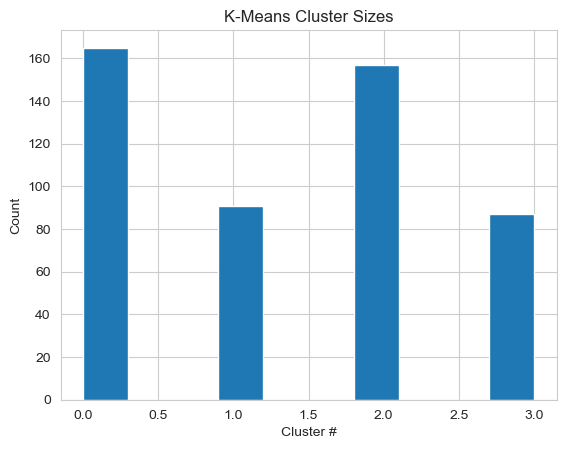

In [35]:
# Plot KC Cluster Distribution
plt.hist(nba_df['KC_Cluster'])
plt.title('K-Means Cluster Sizes')
plt.xlabel('Cluster #')
plt.ylabel('Count')

## Final Model Selection

The final model I decided to use for this project was the Agglomerative Clustering with Ward Linkage. While the K-Means Clustering had a better Silhouette Coefficient score of 0.222 (n_clusters = 4) compared to 0.184 for Agglomerative Clustering (n_clusters = 5), I chose to use the Agglomerative Clustering because it offered a more definitive selection for the optimal number of clusters and I felt that 4 clusters using K-Means were not enough for a pool of 500 players. 

In [36]:
# Drop KC_Cluster labels from df
nba_df = nba_df.drop(columns='KC_Cluster')

In [47]:
# First Agglomerative Cluster
AC0 = nba_df.loc[nba_df['AC_Cluster'] == 0]
AC0.head(60)

Pos   G    MP   FG  FGA    FG%   3P  3PA    3P%  \
Player                                                                      
Precious Achiuwa            C  73  23.6  3.6  8.3  0.439  0.8  2.1  0.359   
LaMarcus Aldridge           C  47  22.3  5.4  9.7  0.550  0.3  1.0  0.304   
Kyle Anderson              PF  69  21.5  3.0  6.8  0.446  0.5  1.6  0.330   
Thanasis Antetokounmpo     SF  48   9.9  1.5  2.7  0.547  0.0  0.3  0.143   
Deni Avdija                SF  82  24.2  3.0  7.1  0.432  1.0  3.2  0.317   
Udoka Azubuike              C  17  11.5  2.2  2.9  0.755  0.0  0.0  0.000   
Marvin Bagley III          PF  48  23.9  4.7  9.3  0.504  0.5  2.0  0.237   
Charles Bassey             PF  23   7.3  1.3  2.0  0.638  0.0  0.2  0.000   
Keita Bates-Diop           SF  59  16.2  2.3  4.5  0.517  0.3  0.9  0.309   
Nicolas Batum              PF  59  24.8  3.0  6.6  0.463  1.8  4.6  0.400   
Darius Bazley              PF  69  27.9  4.0  9.4  0.422  1.2  3.9  0.297   
DeAndre' Bembry            SF  56  18.3  2.2  3.9  0.561  0.3  0.6  0.417   
D?vis Bert?ns              PF  56  14.4  1.8  4.9  0.360  1.4  4.1  0.335   
Khem Birch                  C  55  18.0  1.8  3.6  0.485  0.0  0.3  0.000   
Goga Bitadze                C  50  14.6  2.6  5.0  0.520  0.5  1.6  0.288   
Bismack Biyombo             C  36  14.1  2.4  4.0  0.593  0.0  0.0  0.000   
Nemanja Bjelica             C  71  16.1  2.3  4.8  0.468  0.8  2.1  0.362   
Chris Boucher              PF  80  21.1  3.4  7.2  0.464  0.9  2.9  0.297   
Avery Bradley              SG  62  22.7  2.4  5.6  0.423  1.3  3.4  0.390   
Tony Bradley                C  55  10.0  1.3  2.2  0.585  0.0  0.0  0.000   
Oshae Brissett             SF  67  23.3  3.1  7.6  0.411  1.2  3.5  0.350   
Armoni Brooks           SG-PG  54  15.6  1.8  5.4  0.339  1.4  4.6  0.297   
Bruce Brown                SF  72  24.6  3.6  7.0  0.506  0.5  1.3  0.404   
Greg Brown III             SF  48  13.3  1.7  4.0  0.426  0.4  1.3  0.311   
Moses Brown                 C  40   8.6  1.6  2.7  0.593  0.0  0.0  0.000   
Thomas Bryant               C  27  16.3  2.9  5.5  0.520  0.4  1.6  0.286   
Devontae Cacok             PF  15   8.1  1.4  2.1  0.677  0.0  0.0  0.000   
Marquese Chriss            PF  34  10.2  1.8  3.9  0.463  0.2  0.7  0.320   
Josh Christopher           SG  74  18.0  3.0  6.8  0.448  0.8  2.6  0.296   
Brandon Clarke             PF  64  19.5  4.5  7.0  0.644  0.1  0.3  0.227   
Amir Coffey                SG  69  22.7  3.1  6.8  0.453  1.4  3.7  0.378   
Zach Collins               PF  28  17.9  2.7  5.5  0.490  0.5  1.5  0.341   
Pat Connaughton            SG  65  26.0  3.5  7.6  0.458  2.2  5.7  0.395   
Tyler Cook                 PF  20  10.0  1.2  1.9  0.605  0.0  0.0  0.000   
DeMarcus Cousins            C  48  15.0  3.1  6.8  0.460  0.8  2.5  0.303   
Robert Covington        PF-SF  71  27.3  2.9  7.0  0.420  1.8  4.8  0.378   
Torrey Craig               SF  78  20.5  2.6  5.7  0.454  1.0  3.0  0.329   
Jae Crowder                PF  67  28.1  3.2  8.1  0.399  1.9  5.4  0.348   
Ed Davis                    C  31   6.5  0.4  0.5  0.688  0.0  0.0  0.000   
Terence Davis              SG  30  17.9  3.8  8.9  0.423  1.6  5.0  0.329   
Dewayne Dedmon              C  67  15.9  2.4  4.3  0.566  0.3  0.7  0.404   
Mamadi Diakite             PF  13  14.5  1.9  3.6  0.532  0.0  0.4  0.000   
Hamidou Diallo             SG  58  21.9  4.5  9.1  0.496  0.4  1.6  0.247   
Ayo Dosunmu                SG  77  27.4  3.6  6.9  0.520  0.9  2.4  0.376   
Kessler Edwards            SF  48  20.6  2.3  5.6  0.412  1.0  2.8  0.353   
CJ Elleby                  SF  58  20.2  2.1  5.3  0.393  0.6  2.2  0.294   
Wayne Ellington            SG  43  18.8  2.3  5.5  0.414  1.9  4.9  0.389   
Drew Eubanks                C  71  17.5  3.1  5.2  0.596  0.1  0.3  0.217   
Derrick Favors              C  39  16.7  2.4  4.7  0.516  0.1  0.4  0.125   
Dorian Finney-Smith        PF  80  33.1  4.1  8.7  0.471  2.2  5.4  0.395   
Bryn Forbes           

In [38]:
# Second Agglomerative Cluster
AC1 = nba_df.loc[nba_df['AC_Cluster'] == 1]
AC1

Pos   G    MP   FG   FGA    FG%   3P  3PA    3P%   2P  \
Player                                                                        
Steven Adams            C  76  26.3  2.8   5.1  0.547  0.0  0.0  0.000  2.8   
Bam Adebayo             C  56  32.6  7.3  13.0  0.557  0.0  0.1  0.000  7.3   
Jarrett Allen           C  56  32.3  6.6   9.7  0.677  0.0  0.2  0.100  6.6   
Deandre Ayton           C  58  29.5  7.6  12.0  0.634  0.1  0.3  0.368  7.5   
Mo Bamba                C  71  25.7  4.2   8.7  0.480  1.5  4.0  0.381  2.7   
Scottie Barnes         PF  74  35.4  6.2  12.6  0.492  0.8  2.6  0.301  5.4   
Miles Bridges          PF  80  35.5  7.5  15.2  0.491  1.9  5.8  0.331  5.5   
Clint Capela            C  74  27.6  5.0   8.2  0.613  0.0  0.0  0.000  5.0   
Wendell Carter Jr.      C  62  29.9  5.8  11.0  0.525  1.1  3.5  0.327  4.7   
Nic Claxton             C  47  20.7  3.8   5.6  0.674  0.0  0.0  0.000  3.8   
John Collins           PF  54  30.8  6.3  11.9  0.526  1.2  3.3  0.364  5.1   
Anthony Davis           C  40  35.1  9.3  17.4  0.532  0.3  1.8  0.186  8.9   
Andre Drummond          C  73  19.7  3.4   5.9  0.570  0.0  0.0  0.000  3.4   
Daniel Gafford          C  72  20.1  4.0   5.7  0.693  0.0  0.0  0.000  4.0   
Josh Giddey            SG  54  31.5  5.2  12.4  0.419  1.0  3.9  0.263  4.2   
Rudy Gobert             C  66  32.1  5.5   7.7  0.713  0.0  0.1  0.000  5.5   
Aaron Gordon           PF  75  31.7  5.8  11.1  0.520  1.2  3.5  0.335  4.6   
Draymond Green         PF  46  28.9  2.9   5.6  0.525  0.3  1.2  0.296  2.6   
Josh Hart           SG-SF  54  33.2  5.3  10.5  0.504  1.4  3.9  0.343  4.0   
Al Horford              C  69  29.1  3.9   8.2  0.467  1.3  3.8  0.336  2.6   
Jaren Jackson Jr.      PF  78  27.3  5.5  13.3  0.415  1.6  5.1  0.319  3.9   
Kyle Kuzma             PF  66  33.4  6.4  14.2  0.452  1.9  5.7  0.341  4.5   
Kevon Looney            C  82  21.1  2.5   4.4  0.571  0.0  0.0  0.000  2.5   
Evan Mobley            PF  69  33.8  6.1  12.0  0.508  0.3  1.3  0.250  5.8   
Jusuf Nurki?            C  56  28.2  5.7  10.7  0.535  0.3  1.0  0.268  5.5   
Onyeka Okongwu          C  48  20.7  3.3   4.7  0.690  0.0  0.0  0.000  3.3   
Mason Plumlee           C  73  24.6  2.8   4.4  0.641  0.0  0.0  0.000  2.8   
Jakob Poeltl            C  68  29.0  6.0   9.8  0.618  0.0  0.0  1.000  6.0   
Bobby Portis            C  72  28.2  5.8  12.1  0.479  1.8  4.7  0.393  3.9   
Kristaps Porzi??is     PF  51  29.0  6.9  15.0  0.459  1.5  4.9  0.310  5.4   
Mitchell Robinson       C  72  25.7  3.6   4.8  0.761  0.0  0.0  0.000  3.6   
Domantas Sabonis     C-PF  62  34.5  7.1  12.5  0.573  0.6  2.0  0.312  6.5   
Myles Turner            C  42  29.4  4.8   9.4  0.509  1.5  4.4  0.333  3.3   
Jonas Valan?i?nas       C  74  30.3  6.9  12.7  0.544  0.8  2.1  0.361  6.1   
Jarred Vanderbilt      PF  74  25.4  2.9   4.9  0.587  0.0  0.2  0.143  2.8   
Nikola Vu?evi?          C  73  33.1  7.5  15.8  0.473  1.4  4.5  0.314  6.1   
Hassan Whiteside        C  65  17.9  3.3   5.1  0.652  0.0  0.0  0.000  3.3   
Robert Williams         C  61  29.6  4.4   6.0  0.736  0.0  0.0  0.000  4.4   
Christian Wood          C  68  30.8  6.5  12.9  0.501  1.9  4.9  0.390  4.5   
Ivica Zubac             C  76  24.4  4.1   6.5  0.626  0.0  0.0  0.000  4.1   

                    ...  ORB   DRB   TRB  AST  STL  BLK  TOV   PF   PTS  \
Player              ...                                                   
Steven Adams        ...  4.6   5.4  10.0  3.4  0.9  0.8  1.5  2.0   6.9   
Bam Adebayo         ...  2.4   7.6  10.1  3.4  1.4  0.8  2.6  3.1  19.1   
Jarrett Allen       ...  3.4   7.3  10.8  1.6  0.8  1.3  1.7  1.7  16.1   
Deandre Ayton       ...  2.6   7.7  10.2  1.4  0.7  0.7  1.6  2.4  17.2   
Mo Bamba            ...  2.1   6.0   8.1  1.2  0.5  1.7  1.1  2.6  10.6   
Scottie Barnes      ...  2.6   4.9   7.5  3.5  1.1  0.7  1.8  2.6  15.3   
Miles Bridges       ...  1.1   5.9   7.0  3.8  0.9  0.8  1.9  2.4  20.2   
Clint Capela        ...  3.8

In [49]:
# Third Agglomerative Cluster
AC2 = nba_df.loc[nba_df['AC_Cluster'] == 2]
AC2.head(50)

Pos   G    MP   FG  FGA    FG%   3P  3PA    3P%   2P  \
Player                                                                        
Santi Aldama            PF  32  11.3  1.7  4.1  0.402  0.2  1.5  0.125  1.5   
Jose Alvarado           PG  54  15.4  2.4  5.4  0.446  0.6  2.0  0.291  1.8   
Justin Anderson         SF  16  19.8  2.3  5.9  0.379  0.9  3.7  0.254  1.3   
Ryan Arcidiacono        PG  10   7.6  0.6  1.2  0.500  0.4  0.9  0.444  0.2   
Trevor Ariza            SF  24  19.3  1.4  4.1  0.333  0.8  3.1  0.270  0.5   
D.J. Augustin           PG  55  16.1  1.7  4.0  0.423  1.2  3.0  0.415  0.5   
Dalano Banton           SF  64  10.9  1.3  3.2  0.411  0.2  0.8  0.255  1.1   
Kent Bazemore           SF  39  14.0  1.2  3.6  0.324  0.7  2.1  0.363  0.4   
Keljin Blevins          SF  31  11.3  1.1  3.6  0.306  0.7  2.3  0.292  0.4   
Bol Bol                 PF  14   5.8  1.1  1.9  0.556  0.1  0.3  0.250  1.0   
Leandro Bolmaro         SF  35   6.9  0.5  1.5  0.315  0.1  0.5  0.278  0.3   
Isaac Bonga             SF  15   4.6  0.2  0.9  0.231  0.1  0.3  0.250  0.1   
Brandon Boston Jr.      SG  51  14.9  2.5  6.4  0.385  0.7  2.2  0.306  1.8   
James Bouknight         SG  31   9.8  1.6  4.5  0.348  0.5  1.6  0.347  1.0   
Ignas Brazdeikis        SF  42  12.8  1.9  4.5  0.431  0.6  2.1  0.310  1.3   
Charlie Brown Jr.       SG  22   8.0  0.5  1.8  0.256  0.0  0.5  0.083  0.4   
Sterling Brown          SG  49  12.8  1.2  3.2  0.381  0.6  1.9  0.304  0.6   
Troy Brown Jr.          SF  66  16.0  1.6  3.9  0.419  0.7  2.0  0.353  0.9   
Trey Burke              PG  42  10.5  2.0  5.1  0.391  0.6  2.0  0.317  1.4   
Jared Butler            SG  42   8.6  1.5  3.6  0.404  0.7  2.1  0.318  0.8   
Facundo Campazzo        PG  65  18.2  1.6  4.6  0.361  0.9  3.0  0.301  0.8   
Vlatko ?an?ar           PF  15  11.7  1.5  2.7  0.561  0.5  0.8  0.583  1.1   
Jevon Carter            PG  66  13.7  1.5  3.8  0.387  1.0  2.6  0.388  0.5   
Willie Cauley-Stein      C  20   9.2  0.8  1.8  0.457  0.1  0.1  0.500  0.8   
Justin Champagnie       SF  36   7.8  0.9  1.9  0.463  0.3  0.8  0.357  0.6   
Chris Chiozza           PG  34  10.9  0.7  2.4  0.296  0.5  1.6  0.321  0.2   
Gary Clark              PF  38   9.9  0.9  2.3  0.375  0.7  1.8  0.400  0.1   
Sharife Cooper          PG  13   3.0  0.2  1.1  0.214  0.1  0.5  0.167  0.2   
Petr Cornelie           PF  13   2.9  0.4  1.2  0.333  0.1  0.6  0.125  0.3   
Jarrett Culver          SG  37   9.1  1.4  3.6  0.378  0.3  1.3  0.255  1.1   
Gorgui Dieng             C  44   8.4  1.2  2.5  0.473  0.7  1.5  0.426  0.5   
Devon Dotson            PG  11   7.7  1.0  2.1  0.478  0.2  0.8  0.222  0.8   
PJ Dozier               SG  18  18.9  2.0  5.5  0.364  0.8  2.7  0.313  1.2   
David Duke Jr.          PG  22  15.5  1.8  4.9  0.361  0.4  1.7  0.243  1.4   
Tacko Fall               C  11   5.4  0.5  1.1  0.417  0.0  0.0  0.000  0.5   
Bruno Fernando           C  30   5.1  1.2  1.8  0.655  0.0  0.1  0.500  1.2   
Malik Fitts             PF  15   4.2  0.5  1.3  0.421  0.3  0.7  0.500  0.2   
Malachi Flynn           PG  44  12.2  1.6  4.2  0.393  0.7  2.0  0.333  1.0   
Trent Forrest           PG  60  12.8  1.3  2.6  0.490  0.1  0.5  0.185  1.2   
Tim Frazier             PG  12  17.3  1.2  3.8  0.311  0.5  1.4  0.353  0.7   
Marcus Garrett          SG  12  10.7  0.4  1.8  0.238  0.1  0.3  0.250  0.3   
Anthony Gill            PF  44  10.5  1.4  2.5  0.569  0.3  0.6  0.538  1.1   
Brandon Goodwin         PG  36  13.9  1.8  4.3  0.416  0.5  1.5  0.345  1.3   
Kyle Guy                SG  19   9.8  1.4  3.4  0.400  0.7  2.1  0.350  0.6   
R.J. Hampton            SG  64  21.9  2.7  7.1  0.383  1.0  2.9  0.350  1.7   
Udonis Haslem            C  13   6.4  1.1  2.4  0.452  0.1  0.3  0.250  1.0   
Sam Hauser              SF  26   6.1  0.9  1.9  0.460  0.7  1.7  0.432  0.2   
Juancho Hernangómez     PF  40  11.1  1.1  2.7  0.415  0.6  1.7  0.348  0.5   
Haywood Highsmith       SF  19   8.6  0.8  2.4  0.348  0.5  1.5  0.321  0

In [50]:
# Fourth Agglomerative Cluster
AC3 = nba_df.loc[nba_df['AC_Cluster'] == 3]
AC3.head(40)

Pos   G    MP   FG   FGA    FG%   3P  3PA    3P%  \
Player                                                                         
Nickeil Alexander-Walker     SG  65  22.6  3.9  10.5  0.372  1.6  5.2  0.311   
Grayson Allen                SG  66  27.3  3.9   8.6  0.448  2.4  5.9  0.409   
Carmelo Anthony              PF  69  26.0  4.6  10.5  0.441  2.2  5.8  0.375   
Cole Anthony                 PG  65  31.7  5.5  14.0  0.391  2.0  6.0  0.338   
OG Anunoby                   SF  48  36.0  6.4  14.5  0.443  2.4  6.6  0.363   
Lonzo Ball                   PG  35  34.6  4.6  10.9  0.423  3.1  7.4  0.423   
Desmond Bane                 SF  76  29.8  6.7  14.5  0.461  3.0  6.9  0.436   
Harrison Barnes              PF  77  33.6  5.1  10.8  0.469  1.8  4.7  0.394   
RJ Barrett                   SF  70  34.5  7.0  17.1  0.408  2.0  5.8  0.342   
Will Barton                  SG  71  32.1  5.5  12.6  0.438  2.2  6.1  0.365   
Malik Beasley                SG  79  25.0  4.2  10.8  0.391  3.0  8.1  0.377   
Patrick Beverley             PG  58  25.4  3.1   7.5  0.406  1.4  4.2  0.343   
Saddiq Bey                   SF  82  33.0  5.5  13.9  0.396  2.6  7.4  0.346   
Eric Bledsoe                 PG  54  25.2  3.6   8.7  0.421  0.9  3.0  0.313   
Bogdan Bogdanovi?            SG  63  29.3  5.4  12.6  0.431  2.7  7.3  0.368   
Bojan Bogdanovi?             PF  69  30.9  6.1  13.4  0.455  2.6  6.8  0.387   
Mikal Bridges                SF  82  34.8  5.6  10.5  0.534  1.4  3.8  0.369   
Malcolm Brogdon              PG  36  33.5  6.8  15.1  0.448  1.6  5.2  0.312   
Dillon Brooks                SF  32  27.7  7.1  16.4  0.432  1.4  4.7  0.309   
Jalen Brunson                PG  79  31.9  6.4  12.8  0.502  1.2  3.2  0.373   
Reggie Bullock               SF  68  28.0  3.0   7.4  0.401  2.1  5.8  0.360   
Alec Burks                   SG  81  28.6  3.5   9.0  0.391  1.9  4.8  0.404   
Kentavious Caldwell-Pope     SG  77  30.2  4.7  10.8  0.435  2.1  5.3  0.390   
Alex Caruso                  SG  41  28.0  2.5   6.2  0.398  1.0  3.1  0.333   
Jordan Clarkson              SG  79  27.1  5.9  14.1  0.419  2.4  7.6  0.318   
Mike Conley                  PG  72  28.6  4.8  11.0  0.435  2.3  5.8  0.408   
Seth Curry                   SG  64  33.4  5.6  11.5  0.487  2.5  5.8  0.422   
Spencer Dinwiddie            PG  67  29.6  4.6  11.0  0.416  1.7  4.9  0.339   
Donte DiVincenzo             SG  42  24.0  2.8   8.0  0.351  1.8  5.2  0.339   
Luguentz Dort                SF  51  32.6  5.7  14.2  0.404  2.5  7.7  0.332   
Goran Dragi?                 PG  21  23.7  2.7   7.2  0.377  0.8  3.0  0.254   
Chris Duarte                 SG  55  28.0  4.9  11.3  0.432  1.7  4.6  0.369   
Kris Dunn                    PG  14  24.0  3.1   7.3  0.431  0.1  0.8  0.091   
Evan Fournier                SG  80  29.5  5.0  12.1  0.417  3.0  7.7  0.389   
Markelle Fultz               PG  18  20.0  4.6   9.7  0.474  0.2  0.9  0.235   
Eric Gordon                  SG  57  29.3  4.7   9.9  0.475  2.2  5.3  0.412   
Devonte' Graham              PG  76  28.4  3.9  10.7  0.363  2.5  7.4  0.341   
Jerami Grant                 PF  47  31.9  6.3  14.9  0.426  1.9  5.4  0.358   
Jalen Green                  SG  67  31.9  6.1  14.2  0.426  2.3  6.8  0.343   
Tyrese Haliburton         SG-PG  77  35.0  5.6  11.8  0.473  2.1  5.1  0.414   

                           2P  ...  ORB  DRB  TRB  AST  STL  BLK  TOV   PF  \
Player                         ...                                           
Nickeil Alexander-Walker  2.3  ...  0.6  2.3  2.9  2.4  0.7  0.4  1.4  1.6   
Grayson Allen             1.5  ...  0.5  2.9  3.4  1.5  0.7  0.3  0.7  1.5   
Carmelo Anthony           2.5  ...  0.9  3.3  4.2  1.0  0.7  0.8  0.9  2.4   
Cole Anthony              3.5  ...  0.5  4.9  5.4  5.7  0.7  0.3  2.6  2.6   
OG Anunoby                4.0  ...  1.5  4.0  5.5  2.6  1.5  0.5  1.7  2.7   
Lonzo Ball                1.5  ...  1.0  4.4  5.4  5.1  1.8  0.9  2.3  2.4   
Desmond Bane              3.7  ...  0.6  3.

In [41]:
# Fifth Agglomerative Cluster
AC4 = nba_df.loc[nba_df['AC_Cluster'] == 4]
AC4

Pos   G    MP    FG   FGA    FG%   3P   3PA    3P%  \
Player                                                                          
Giannis Antetokounmpo       PF  67  32.9  10.3  18.6  0.553  1.1   3.6  0.293   
LaMelo Ball                 PG  75  32.3   7.2  16.7  0.429  2.9   7.5  0.389   
Bradley Beal                SG  40  36.0   8.7  19.3  0.451  1.6   5.3  0.300   
Devin Booker                SG  68  34.5   9.7  20.9  0.466  2.7   7.0  0.383   
Jaylen Brown                SF  66  33.6   8.7  18.4  0.473  2.5   7.0  0.358   
Jimmy Butler                SF  57  33.9   7.0  14.5  0.480  0.5   2.0  0.233   
Cade Cunningham             PG  64  32.6   6.7  16.1  0.416  1.8   5.7  0.314   
Stephen Curry               PG  64  34.5   8.4  19.1  0.437  4.5  11.7  0.380   
DeMar DeRozan               PF  76  36.1  10.2  20.2  0.504  0.7   1.9  0.352   
Luka Don?i?                 PG  65  35.4   9.9  21.6  0.457  3.1   8.8  0.353   
Kevin Durant                PF  55  37.2  10.5  20.3  0.518  2.1   5.5  0.383   
Anthony Edwards             SG  72  34.3   7.6  17.3  0.441  3.0   8.4  0.357   
Joel Embiid                  C  68  33.8   9.8  19.6  0.499  1.4   3.7  0.371   
De'Aaron Fox                PG  59  35.3   8.7  18.5  0.473  1.3   4.2  0.297   
Darius Garland              PG  68  35.7   8.0  17.3  0.462  2.6   6.7  0.383   
Paul George                 SF  31  34.7   8.6  20.5  0.421  2.9   8.3  0.354   
Shai Gilgeous-Alexander     PG  56  34.7   8.5  18.8  0.453  1.6   5.3  0.300   
James Harden             PG-SG  65  37.2   6.3  15.3  0.410  2.3   6.9  0.330   
Brandon Ingram              SF  55  34.0   8.2  17.9  0.461  1.3   4.1  0.327   
Kyrie Irving                PG  29  37.6  10.0  21.2  0.469  3.4   8.2  0.418   
LeBron James                SF  56  37.2  11.4  21.8  0.524  2.9   8.0  0.359   
Nikola Joki?                 C  74  33.5  10.3  17.7  0.583  1.3   3.9  0.337   
Zach LaVine                 SF  67  34.7   8.4  17.7  0.476  2.8   7.1  0.389   
Damian Lillard              PG  29  36.4   7.7  19.0  0.402  3.2   9.8  0.324   
CJ McCollum                 SG  62  34.6   8.6  18.8  0.460  2.9   7.6  0.388   
Khris Middleton             SF  66  32.4   6.8  15.5  0.443  2.5   6.6  0.373   
Donovan Mitchell            SG  67  33.8   9.2  20.5  0.448  3.5   9.8  0.355   
Ja Morant                   PG  57  33.1  10.2  20.6  0.493  1.5   4.5  0.344   
Dejounte Murray             PG  68  34.8   8.4  18.3  0.462  1.4   4.3  0.327   
Julius Randle               PF  72  35.3   7.1  17.3  0.411  1.7   5.4  0.308   
D'Angelo Russell            PG  65  32.0   6.2  15.0  0.411  2.7   8.0  0.340   
Pascal Siakam               PF  68  37.9   8.8  17.8  0.494  1.1   3.2  0.344   
Jayson Tatum                SF  76  35.9   9.3  20.6  0.453  3.0   8.6  0.353   
Karl-Anthony Towns           C  74  33.5   8.7  16.4  0.529  2.0   4.9  0.410   
Fred VanVleet               PG  65  37.9   6.8  16.9  0.403  3.7   9.9  0.377   
Russell Westbrook           PG  78  34.3   7.0  15.8  0.444  1.0   3.4  0.298   
Trae Young                  PG  76  34.9   9.4  20.3  0.460  3.1   8.0  0.382   

                          2P  ...  ORB   DRB   TRB   AST  STL  BLK  TOV   PF  \
Player                        ...                                              
Giannis Antetokounmpo    9.2  ...  2.0   9.6  11.6   5.8  1.1  1.4  3.3  3.2   
LaMelo Ball              4.2  ...  1.4   5.2   6.7   7.6  1.6  0.4  3.3  3.2   
Bradley Beal             7.1  ...  1.0   3.8   4.7   6.6  0.9  0.4  3.4  2.4   
Devin Booker             7.0  ...  0.7   4.4   5.0   4.8  1.1  0.4  2.4  2.6   
Jaylen Brown             6.2  ...  0.8   5.3   6.1   3.5  1.1  0.3  2.7  2.5   
Jimmy Butler             6.5  ...  1.8   4.1   5.9   5.5  1.6  0.5  2.1  1.5   
Cade Cunningham          4.9  ...  0.9   4.6   5.5   5.6  1.2  0.7  3.7  3.1   
Stephen Curry            3.9  ...  0.5   4.7   5.2   6.3  1.3  0.4  3.2  2.0   
DeMar DeRozan            9.5  ...  0.7   4.4   5.2   4.9  0.9  0.3 

### Aggegrate by Cluster to Show Cluster Level Stats

In [42]:
# Aggegrate Clusters by mean
cluster_summary = nba_df.groupby(['AC_Cluster']).mean()
cluster_summary = cluster_summary.reset_index(drop=False)
cluster_summary_T = cluster_summary.T[1:]
cluster_summary_T = cluster_summary_T.rename(columns={0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4'})
cluster_summary_T

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
G     54.181319  64.675000  34.475862  61.104167  62.702703
MP    19.410440  28.602500  11.505517  29.001042  34.824324
FG     2.826923   5.262500   1.388276   4.988542   8.575676
FGA    5.903846   9.717500   3.475862  11.529167  18.435135
FG%    0.490962   0.562225   0.398566   0.431219   0.464027
3P     0.796154   0.642500   0.517241   1.994792   2.259459
3PA    2.283516   1.970000   1.635172   5.442708   6.345946
3P%    0.305489   0.216625   0.301559   0.358802   0.348189
2P     2.033516   4.612500   0.873103   2.994792   6.316216
2PA    3.619780   7.745000   1.843448   6.087500  12.089189
2P%    0.564231   0.602575   0.471869   0.490177   0.518892
eFG%   0.552489   0.589950   0.471717   0.519437   0.525135
FT     1.060989   2.195000   0.500690   1.916667   4.745946
FTA    1.429121   3.130000   0.699310   2.352083   5.767568
FT%    0.733940   0.689350   0.684552   0.819104   0.823703
ORB    1.081319   2.460000   0.430345   0.627083   1.035135
DRB    2.813736   6.292500   1.328966   3.163542   5.448649
TRB    3.893956   8.762500   1.757931   3.794792   6.472973
AST    1.326374   2.445000   1.077931   3.379167   6.156757
STL    0.615934   0.802500   0.366897   0.912500   1.200000
BLK    0.464835   1.162500   0.173103   0.327083   0.543243
TOV    0.853297   1.652500   0.540000   1.575000   3.102703
PF     1.873626   2.587500   0.995172   2.035417   2.389189
PTS    7.502198  13.350000   3.797931  13.889583  24.159459

In [43]:
lst = ['G', 'MP', 'PTS', 
       'AST', 'STL', 'BLK', 
       'FG', 'FGA', 'FG%', 
       '3P', '3PA', '3P%', 
       '2P', '2PA', '2P%', 
       'FT', 'FTA', 'FT%', 
       'ORB', 'DRB', 'TRB', 
       'TOV', 'PF', 'eFG%']

In [44]:
# Visualize Clusters using bar charts
fig, axs = plt.subplots(8, 3, sharey=False, tight_layout=True, figsize=(16,30))
coln=0

for i in range(0,8):
    for j in range(0,3):
        col=lst[coln]
        coln=coln+1
        axs[i,j].bar(cluster_summary['AC_Cluster'], height=cluster_summary[col], color = ['red', 'blue', 'green', 'purple', 'orange'])
        axs[i,j].set(title=col)
        axs[i,j].set_xticks(ticks=(0,1,2, 3, 4), minor=False)
plt.show()

## Conclusion

To start the modeling process I first applied a Principal Component Analysis on the data as a means for dimensionality reduction for more efficient analysis. I narrowed it down to the first 10 PCA components because they account for about 95 of the variance of the data. 

The first unsupervised learning model I applied was K-Means Clustering. In order to identify the optimal number of K to choose for my model, I first used the Elbow Method. Based on the elbow method, I chose K=6, but there was no clear point at which K started to descend more slowly. I then attempted to determine the best K using the Silhouette Method. Using the Silhouette Method, the optimal number of K was K=4, with an average silhouette score of 0.222. I then applied the K-Means Clustering Model with K=4 and made a scatterplot to visualize the clusters. 

The next unsupervised learning model I applied was the Agglomerative Hierarchical Clustering with Ward linkage. I first determine the optimal number of clusters using a dendrogram. The optimal number of clusters was 5, which I determined by identifying the area in the chart with the highest vertical distance that does not intersect with any clusters. I then applied the Agglomerative Clustering method to the data and made a scatterplot to visualize the clusters.

For the final model selection for this project, I decided to use the Agglomerative Clustering with Ward Linkage. While the K-Means Clustering had a higher Silhouette Coefficient score of 0.222 (n_clusters = 4) compared to 0.184 for Agglomerative Clustering (n_clusters = 5), I chose to use the Agglomerative Clustering because it offered a clearer selection for the optimal number of clusters at K=5 and I also felt that 4 clusters were not enough to differentiate a pool of 500 players. 

Lastly, I aggregated the clusters in order to calculate cluster-level statistics and visualize how each cluster differ between each feature.

**Clusters**

***Cluster 0: Role Players***
- Averaged > 54 games played at 19.4 minutes
- Low- to Mid- tiered in most categories: PTS, AST, STL, BLK, TRB
- Highest count with 182 players

***Cluster 1: Traditional Big Men***
- Highest-tiered in TRB, BLK, FG%, 2P%
- •	Low-tiered in 3PA, 3P%, FT%

***Cluster 2: Fringe Bench Players***
- Low G, MP
- Lowest-tiered in every category besides 3P%
- Second highest count with 145 players

***Cluster 3: Shooter / Defenders ("3- and D- Players")***
- High PTS, 3P, 3P%, FT%
- High STL, BLK

***Cluster 4: Versatile All-Around Players ("All-Stars')***
- Highest-tiered in most categories including MP, PTS, AST, STL, FTA, TOV
- Lowest count with only 37 players